In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join(r"G:\Work\safe_cascade"))
if module_path not in sys.path:
    sys.path.append(module_path)
import geopandas as gpd
import pandas as pd

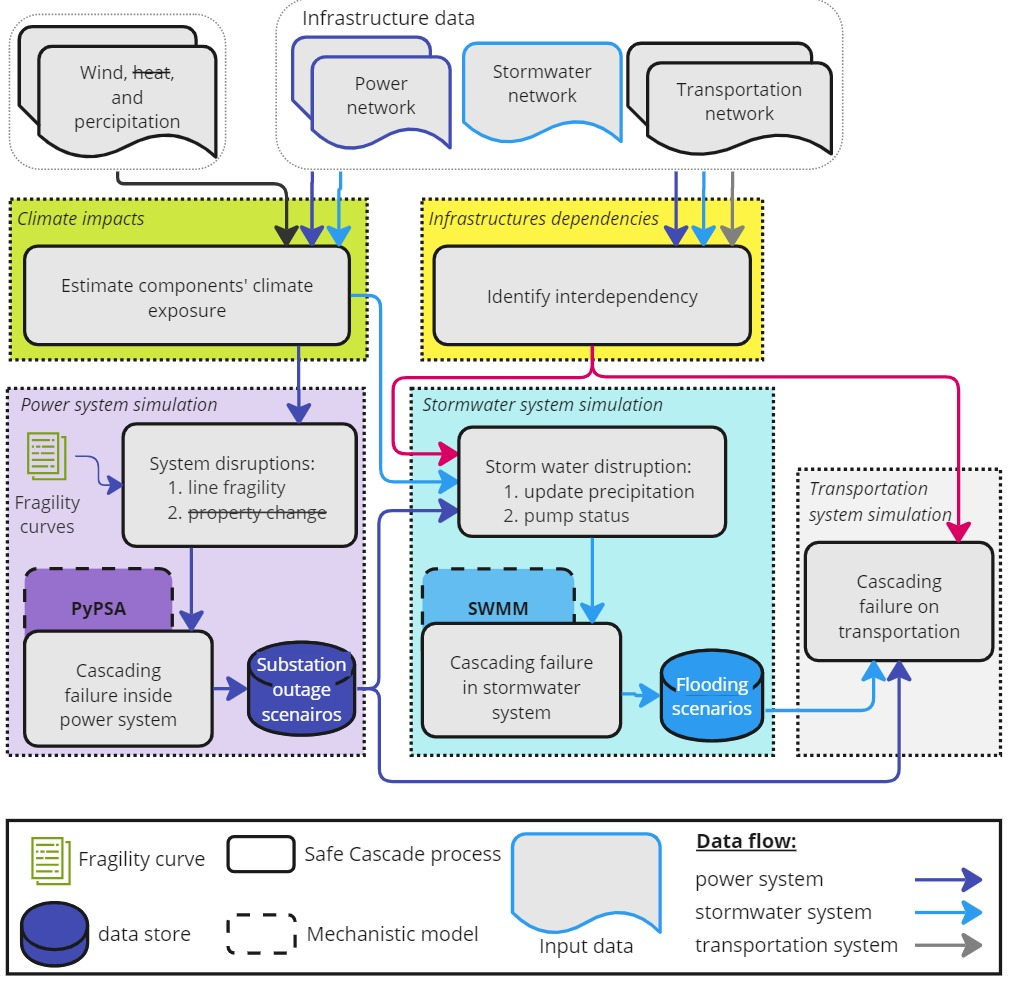

## input files

In [4]:
#stormwater system: .inp file used for SWMM simulation. and .shp file for the subcatchment 
stormwater_file = r"C:\Dropbox (ASU)\DRRG_NIST\Data\StormwaterModel\Model1\RL_test\Model_3_pump.inp"
stormwater_subcatchment = r"C:\Dropbox (ASU)\DRRG_NIST\Data\StormwaterModel\Model1\Subcatchments.shp"
#power system: the folder location hosts the power files
power_folder = r"C:\Dropbox (ASU)\DRRG_NIST\Data\RuiLi\infrastructure data\Power\synthetic\PowerSystem"
#wind data (preprocessed localy)
wind_raster = r"C:\Dropbox (ASU)\DRRG_NIST\Data\RuiLi\test_July_2023\New folder\dt\neighbor_maximum.tif"
rainfall = r"C:\Dropbox (ASU)\DRRG_NIST\Data\SWMM_SimulationScenarios\2018July9\Precipitation_mm_per_h"

In [5]:
from rasterstats import zonal_stats
tif_files = [file for file in os.listdir(rainfall) if file.endswith('.tif')]
subcatchments = gpd.read_file(stormwater_subcatchment)
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import numpy as np

# Load vector data (shapefile or GeoJSON)
vector_path = "path/to/your/vector_file.shp"
vector_data = subcatchments
polygons = subcatchments['geometry'].unary_union

# Load raster data using rasterio
pattern = r'\b\d{2}-\d{2}-\d{2}\b'

result = {}
# Loop through each geometry in the vector data and calculate zonal statistics
for _ in tif_files:
    matches = re.findall(pattern, _)
    if len(matches)>0:
        raster_path =  f'{rainfall}\\{_}'
        raster_dataset = rasterio.open(raster_path)
        raster_array = raster_dataset.read(1)  # Assuming it's a single-band raster
        masked_data, masked_transform = mask(raster_dataset, [polygons], crop=True)
        hours, minutes, seconds = matches[0].split('-')

        # Check if all values in the array are equal to 0
        all_zero = np.extract(masked_data[0] != 0, masked_data[0])
        if len(all_zero[~np.isnan(all_zero)])>0:
            _result = []
            for index, row in vector_data.iterrows():
                geometry = row['geometry']

                # Extract raster values within the geometry using rasterio.mask
                masked_data, masked_transform = mask(raster_dataset, [geometry], crop=True)

                # Calculate statistics (e.g., mean, median, etc.) from the masked data
                mean_value = np.mean(masked_data)

                # Print or store the calculated statistics
                _result.append(mean_value)
            result[f"{hours}:{minutes}"]=_result
            
def get_non_zero_rows(dt, check_v = 0):
    all_zero_rows = dt>check_v
    all_zero_rows = all_zero_rows.any(axis=1)
    return dt[all_zero_rows]

# drop all 0 rows
df = get_non_zero_rows(pd.DataFrame.from_dict(result))       
df['RowSum'] = df.mean(axis=1)

df.reset_index().groupby('RowSum').agg({'index':list}).reset_index().head(10)

_r = []
for index, row in df.reset_index().groupby('RowSum').agg({'index':list}).reset_index().iterrows():
    sub_catchments = row['index']
    rainfall_values = pd.DataFrame.from_dict(result).loc[sub_catchments[0]].to_dict()
    _t = []
    stop_rain = False
    rain = False
    for _time, _value in rainfall_values.items():
        if _value >0: 
            rain = True
            formatted_entry = {'Name':index, 'time': _time, 'value': _value}
            _r.append(formatted_entry)
        elif rain and _value ==0:
            #rain stopped
            rain = False
            formatted_entry = {'Name':index, 'time': _time, 'value': _value}
            _r.append(formatted_entry)
        
subcatchment_pre_index = df.reset_index().groupby('RowSum').agg({'index':list}).reset_index()
subcatchment_pre_index['name'] = subcatchment_pre_index.index

In [145]:
subcatchment_pre_index

,RowSum,index,name
0,0.057971,"[2075, 2076, 2079, 9154]",0
1,0.068921,"[4541, 9631]",1
2,0.086957,"[2078, 9130]",2
3,0.103382,"[3411, 3413, 3449, 4654, 9517]",3
4,0.115942,[9494],4
...,...,...,...
416,8.957671,"[439, 453, 528, 1041, 4137, 5436, 5445, 5464, ...",416
417,9.394967,[3326],417
418,9.546362,"[9282, 9285, 9513]",418
419,9.804237,"[8964, 9363, 9413, 9428, 9458, 9485]",419


In [153]:
subcatchment_precip_name = []
for index, row in subcatchment_pre_index.iterrows():
    subcatchment_precip_name.extend([{"subcatchment":_, "raingage": row['name']} for _ in row['index']])

In [154]:
pd.DataFrame(subcatchment_precip_name).to_csv(r'C:\Dropbox (ASU)\DRRG_NIST\Data\SWMM_SimulationScenarios\2018July9\subcatchment_raingage.csv')

In [137]:
# this is the precipitation timeseries.
pd.DataFrame(_r).to_csv(r'C:\Dropbox (ASU)\DRRG_NIST\Data\SWMM_SimulationScenarios\2018July9\precipitation_time_series.csv')

# 1. load stormwater system and power substations to build dependency

### 1.1 read stormwater .inp file and retrive pumps

In [6]:
from Safe_Cascade.load_swmm_inp import load_swmm, return_pumps
def load_pumps(stormwater_file):
    dts = load_swmm(stormwater_file)
    pumps = return_pumps(nodes_df = dts['COORDINATES'], pumps_df = dts['PUMPS'], links_curve_df = dts['VERTICES'])
    return pumps

pumps = load_pumps(stormwater_file)

In [10]:
pd.DataFrame(pumps)

,Name,FromNode,ToNode,Length,Roughness,InOffset,OutOffset,InitFlow,MaxFlow,substation_id,isPump,geometry
0,10866,J12400,J12401,None,None,None,None,None,None,PHOENIX_106,True,"LINESTRING (399819.411 3703060.983, 399826.801..."
1,15605,J18261,J18265,None,None,None,None,None,None,PHOENIX_44,True,"LINESTRING (403073.387 3707795.124, 403095.979..."
2,16092,J18695,J18694,None,None,None,None,None,None,PHOENIX_24,True,"LINESTRING (402157.749 3706655.355, 402158.082..."
3,17831,J7000,J6997,None,None,None,None,None,None,PHOENIX_28,True,"LINESTRING (400099.96 3701083.031, 400086.076 ..."
4,17923,J4506,J20718,None,None,None,None,None,None,PHOENIX_36,True,"LINESTRING (408260.202 3700878.255, 408270.281..."
5,21495,J23326,J13654,None,None,None,None,None,None,PHOENIX_39,True,"LINESTRING (402679.939 3703052.622, 402663.541..."
6,22387,J23914,J23278,None,None,None,None,None,None,PHOENIX_38,True,"LINESTRING (400696.969 3703128.821, 400693.752..."
7,22665,J7051,J24093,None,None,None,None,None,None,PHOENIX_107,True,"LINESTRING (400551.041 3701595.064, 400529.386..."
8,22807,J24201,J8469,None,None,None,None,None,None,PHOENIX_107,True,"LINESTRING (400207.325 3701032.789, 400201.22 ..."
9,22971,J24279,J12146,None,None,None,None,None,None,PHOENIX_39,True,"LINESTRING (401043.924 3703099.513, 401030.818..."


### 1.2 read power service region .shp file and build dependency with pump stations

In [11]:
from Safe_Cascade.build_interdependency import pump_sub_dependency
power_service_region = gpd.read_file(f"{power_folder}\PHX_service_region.shp")
pump_sub_dependency(power_service_region, pumps, pumps_crs = 26912)

# 2. power system simulation (run 100,000 + times on super computer)
###### (including identify the climate, wind to be specific, impact on the transimission lines and identify the vulnerability )

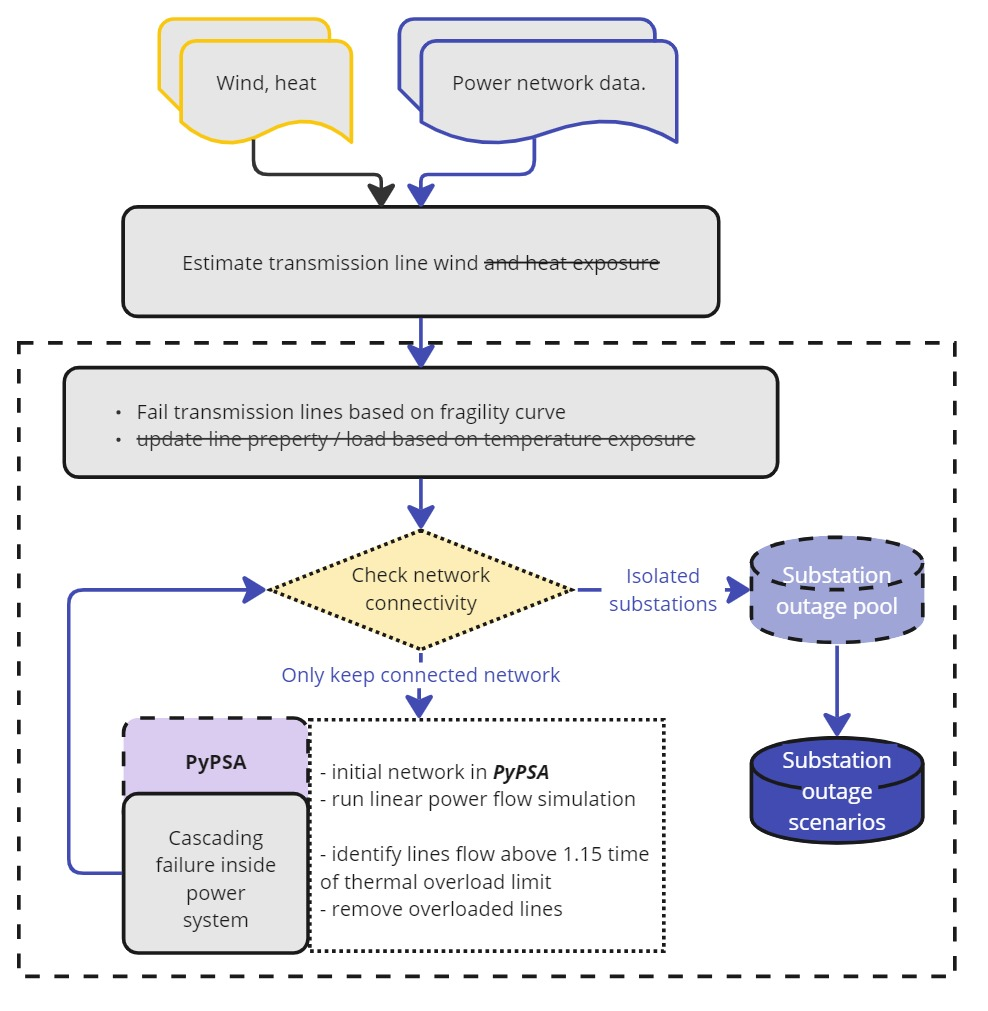

### 2.1 get components (Agave processing starts here)

In [13]:
from Safe_Cascade.util.get_power_components import *

buses = get_buses(f"{power_folder}/buses.csv")
substations = get_substations(f"{power_folder}/substation.csv")
transformers = get_transformers(f"{power_folder}/transformer.csv", buses)
update_names(transformers)
generators = get_generators(f"{power_folder}/gen.csv", buses)
lines = get_transmissionlines(f"{power_folder}/lines.csv", buses, substations)
update_names(lines)
loads = get_loads(f"{power_folder}/load.csv", buses)
# this is where you would adjust r and x in lines with different heat (temperature)

### 2.2 get wind intensity on line and random fail lines

In [14]:
from Safe_Cascade.climate_impact import *

get_wind_at_line(wind_raster = wind_raster, line_list = lines, line_crs = 4326 )


C:\Users\ruili\anaconda3\envs\geo_env\lib\site-packages\rasterstats\io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


In [16]:
pd.DataFrame(lines)

,name,bus1name,bus2name,sub_1,sub_2,r,x,mva_limit,voltage,location,wind_speed,status
0,Line-1-95-1,PHOENIX_169,PHOENIX_7969,PHOENIX_1,PHOENIX_79,0.00786,0.019538,57.7,69,"LINESTRING (-111.964966 33.731036, -111.995684...",19.0,0
1,Line-1-96-1,PHOENIX_169,PHOENIX_8069,PHOENIX_1,PHOENIX_80,0.00630,0.016020,54.0,69,"LINESTRING (-111.964966 33.731036, -111.947621...",19.0,0
2,Line-2-84-1,PHOENIX_269,PHOENIX_7069,PHOENIX_2,PHOENIX_70,0.01382,0.043453,99.6,69,"LINESTRING (-112.115322 33.731036, -112.123326...",22.0,0
3,Line-2-92-1,PHOENIX_269,PHOENIX_7669,PHOENIX_2,PHOENIX_76,0.02783,0.083646,34.9,69,"LINESTRING (-112.115322 33.731036, -112.051228...",22.0,0
4,Line-2-93-1,PHOENIX_269,PHOENIX_7769,PHOENIX_2,PHOENIX_77,0.00996,0.025263,67.3,69,"LINESTRING (-112.115322 33.731036, -112.073102...",22.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
297,Line-159-165-2,Arlington Valley Energy Facility69,Mesquite Solar 169,Arlington Valley Energy Facility,Mesquite Solar 1,0.00391,0.010277,150.0,69,"LINESTRING (-112.8897 33.3417, -112.904028 33....",50.0,0
298,Line-160-164-1,Red Hawk230,Mesquite Solar 1230,Red Hawk,Mesquite Solar 1,0.00037,0.003569,638.9,230,"LINESTRING (-112.840641 33.334562, -112.904028...",50.0,0
299,Line-161-163-1,Red Hawk69,Arlington Valley Solar Energy II69,Red Hawk,Arlington Valley Solar Energy II,0.00972,0.019667,150.0,69,"LINESTRING (-112.840641 33.334562, -112.833888...",50.0,0
300,Line-161-163-2,Red Hawk69,Arlington Valley Solar Energy II69,Red Hawk,Arlington Valley Solar Energy II,0.00972,0.019667,150.0,69,"LINESTRING (-112.840641 33.334562, -112.833888...",50.0,0


In [23]:
new_line = random_fail(lines)
print(f"failed {len(lines) - len(new_line)} lines")

failed 0 lines


### 2.3 check the isolated substations (first time)

In [24]:
from Safe_Cascade.power_simulation import *
len(substations) - len(check_connectivity(substations, lines, 1))

0

### 2.5 build pypsa network and run simulaton. Identify the over flow lines (Still working)

In [25]:
pypsa_network = build_pypsa_network(substations, lines, transformers, buses, generators, loads)
pypsa_network.lpf()
pypsa_network.lines_t.p0.transpose().reset_index()

INFO:pypsa.pf:Performing linear load-flow on AC sub-network SubNetwork 0 for snapshot(s) Index(['now'], dtype='object', name='snapshot')


snapshot,index,now
0,Line-1-95-1,17.320651
1,Line-1-96-1,-19.870651
2,Line-2-84-1,-43.646623
3,Line-2-92-1,5.662771
4,Line-2-93-1,9.333852
...,...,...
297,Line-159-165-2,-78.021618
298,Line-160-164-1,-164.783004
299,Line-161-163-1,-61.053043
300,Line-161-163-2,-61.053043


### 2.6 get substation outage pool (still working) (Agave processing ends here)

### 2.7 identify substation failure scenarios

In [17]:
from collections import Counter
import pandas as pd
import geopandas as gpd
import numpy as np
def get_non_zero_rows(dt, check_v = 0):
    all_zero_rows = dt>check_v
    all_zero_rows = all_zero_rows.any(axis=1)
    return dt[all_zero_rows]

In [18]:
#read pumps service region names
pump_in_region= list(set([_.substation_id for _ in pumps]))

In [19]:
line_f_df = pd.read_csv(r"C:\Dropbox (ASU)\DRRG_NIST\Data\RuiLi\test_July_2023\New folder\out_100000\line_failure.csv").set_index('Unnamed: 0')
sub_f_df = pd.read_csv(r"C:\Dropbox (ASU)\DRRG_NIST\Data\RuiLi\test_July_2023\New folder\out_100000\sub_failure.csv").set_index('Unnamed: 0')

In [22]:
print(f"{len(line_f_df)/100000:.2f} ({len(line_f_df)}) of chance line fail, {len(get_non_zero_rows(sub_f_df))/100000:.2f} ({len(get_non_zero_rows(sub_f_df))})of chance substation fails")

0.60 (60209) of chance line fail, 0.06 (6017)of chance substation fails


In [23]:
print(f"{len(sub_f_df.drop_duplicates())} unique substation failure scenarios")

292 unique substation failure scenarios


In [24]:
pumps_station = sub_f_df[pump_in_region]#sub_f_df[pump_in_region]

In [27]:
def return_failed_stations_scenarios(value, check_cre = 0):
    _ =  [_ for _ in value.keys() if value[_]>check_cre]
    if len(_)> 0:
        return ','.join(_)
    
def return_failed_stations(value, check_cre = 0):
    _ =  [_ for _ in value.keys() if value[_]>check_cre]
    if len(_)> 0:
        return []

In [33]:
_c = get_non_zero_rows(pumps_station)
pump_fail_cases = _c.apply(lambda x:return_failed_stations_scenarios(x), axis = 1).dropna().to_list()
print(f"only {len(set(pump_fail_cases))} pump outage scenarios identified in the 100k simulations")    

only 7 pump outage scenarios identified in the 100k simulations


In [29]:
def return_failed_stations(value, check_cre = 0):
    _ =  [_ for _ in value.keys() if value[_]>check_cre]
    if len(_)> 0:
        return _

In [30]:
pump_fail_times = []
[pump_fail_times.extend(_) for _ in _c.apply(lambda x:return_failed_stations(x), axis = 1).dropna().to_list()]
pump_fail_times = dict(Counter(pump_fail_times))

In [31]:
pump_fail_times

{'PHOENIX_39': 42,
 'PHOENIX_36': 50,
 'PHOENIX_107': 24,
 'PHOENIX_38': 13,
 'PHOENIX_44': 7}

In [3]:
#identify roadways flooding
roadway = gpd.read_file(r"C:\Dropbox (ASU)\DRRG_NIST\Data\RuiLi\test_July_2023\flooding_roadway_section.shp")

In [11]:
result = {}
for _ in ['sce1', 'sce2', 'sce3', 'sce4', 'sce5', 'sce6', 'sce7', 'OG']:
    result[_] = roadway.query(f"{_} > 0").groupby('highway').agg({'length':'count'})['length'].to_dict()

In [13]:
pd.DataFrame(result)

,sce1,sce2,sce3,sce4,sce5,sce6,sce7,OG
cycleway,2.0,2.0,2.0,2.0,2.0,2.0,2,2.0
footway,2.0,3.0,2.0,2.0,2.0,3.0,3,2.0
motorway,1.0,3.0,2.0,1.0,2.0,3.0,3,1.0
motorway_link,5.0,5.0,4.0,4.0,4.0,5.0,5,5.0
primary,22.0,21.0,22.0,24.0,24.0,21.0,25,22.0
residential,66.0,66.0,64.0,64.0,67.0,66.0,67,66.0
secondary,67.0,67.0,66.0,66.0,66.0,67.0,66,67.0
secondary_link,1.0,1.0,1.0,1.0,1.0,1.0,1,1.0
service,26.0,26.0,25.0,27.0,28.0,26.0,28,26.0
tertiary,25.0,25.0,25.0,25.0,25.0,25.0,25,25.0
